In [1]:
import os # File system operations
import re # Regular expressions
import pandas as pd # Tabular data
import numpy as np # Numerical data
pd.set_option('display.max_colwidth', None) # Show full file paths
import sys

# Don't use all of the GPU RAM
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)
from tensorflow.keras import mixed_precision
from tensorflow import keras # ML
import tensorflow_addons as tfa # TQDM progress bar when training
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from skimage import exposure

import mlflow # model runs
mlflow.set_tracking_uri("sqlite:///mlflow.db") # Use sqlite for more efficient storage
# https://www.mlflow.org/docs/latest/python_api/mlflow.tensorflow.html#mlflow.tensorflow.autolog
mlflow.tensorflow.autolog()

BATCH_SIZE = 128
EQUALIZE = False

mixed_precision.set_global_policy('mixed_float16')

from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters


from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from pathlib import Path # Pathing
from glob import glob # Finding files recursively
import matplotlib.pyplot as plt # Plotting
import seaborn as sns # Plotting
sns.set()
from tqdm.auto import tqdm # Progress bars
tqdm.pandas()

BASE_DIR = Path("EmbryoLabeling/Labelers/train")
folders = os.listdir(BASE_DIR)
folders = [f for f in folders if not re.match(r"M\d", f)]
files = []
for folder in folders:
    files_in_folder = pd.DataFrame(glob(f"{BASE_DIR}/{folder}/**/*.jpg", recursive=True), columns=["filename"])
    if len(files_in_folder) == 0:
        print(f"{folder} is empty!")
        os.rmdir(BASE_DIR / folder)
    files_in_folder["class"] = folder
    files.append(files_in_folder)
df = pd.concat(files)
df["class"].value_counts()

2022-06-14 11:01:50.181687: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-14 11:01:50.226718: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-14 11:01:50.226929: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla V100-PCIE-32GB, compute capability 7.0


2022-06-14 11:01:50.806624: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Empty                5913
Blastocyst           2141
2pn                  1910
Morula               1643
2 Cell               1008
Syngamy               974
4 Cell                841
Compacting 8 cell     549
6 Cell                432
8 Cell                431
3 Cell                373
5 Cell                199
Name: class, dtype: int64

<AxesSubplot:>

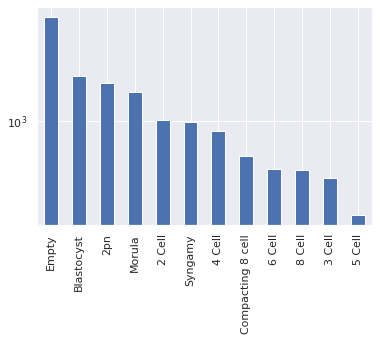

In [2]:
df["class"].value_counts().plot.bar(logy=True)

In [3]:
# Print counts of images by machine and slide
df.filename[~df["class"].isin(["bad", "Empty"])].apply(lambda s: "_".join(s.split("/")[-1].split("_")[:2])).value_counts()

M0776_S00512    1952
M776_S0087      1559
M0776_S00635    1325
M0776_S00534    1232
M3169_S00668    1166
M0776_S00761    1138
M0776_S00470     784
M0831_S00470     466
M0831_S00659     368
M3169_S00737     293
M0776_S00737     218
Name: filename, dtype: int64

In [4]:
# Track a single embryo's lifecycle
pd.set_option('display.max_rows', 365)
M776_S0087_W2 = df[df.filename.str.contains("M776_S0087_W2")].copy()
# Extract time since fertilisation in minutes from filename (ints, rounded to nearest minute)
M776_S0087_W2["time_since_fert"] = M776_S0087_W2.filename.apply(lambda s: s.replace(".jpg", "").split("_")[-1]).astype(int)
M776_S0087_W2 = M776_S0087_W2.sort_values(by="time_since_fert")
# Take the earliest time that each class was seen
M776_S0087_W2 = M776_S0087_W2.groupby("class").head(1)
print(M776_S0087_W2[["class", "time_since_fert"]])

                  class  time_since_fert
957                 2pn             1061
811             Syngamy             1464
414              2 Cell             1574
147              3 Cell             2315
113              4 Cell             2395
9                5 Cell             3045
30               6 Cell             3125
169              8 Cell             3265
24    Compacting 8 cell             3375
1463             Morula             4286
354          Blastocyst             6090
4946              Empty             7036


In [5]:
classes = list(M776_S0087_W2["class"])
classes

['2pn',
 'Syngamy',
 '2 Cell',
 '3 Cell',
 '4 Cell',
 '5 Cell',
 '6 Cell',
 '8 Cell',
 'Compacting 8 cell',
 'Morula',
 'Blastocyst',
 'Empty']

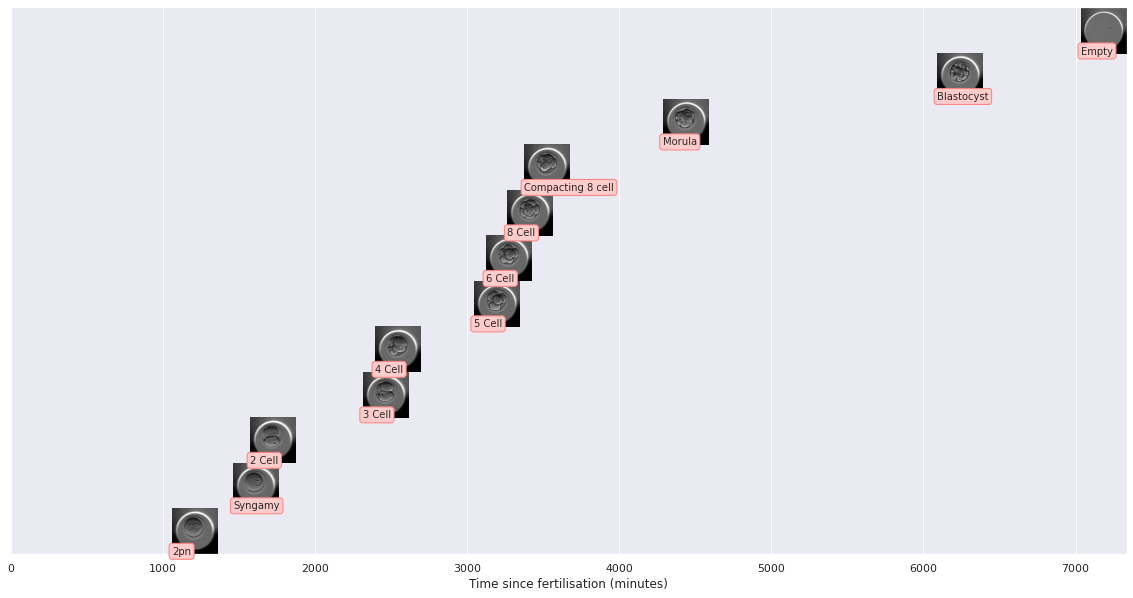

In [6]:
# Plot embryo's lifecycle over time
plt.figure(figsize=(20, 20))
for i, row in M776_S0087_W2.iterrows():
    image = keras.utils.load_img(row.filename, target_size=(299,299))
    c_index = classes.index(row["class"]) * 299
    time_since_fert = row.time_since_fert
    plt.imshow(image, extent=[time_since_fert, time_since_fert+299, c_index, c_index+299])
    plt.text(time_since_fert, c_index, row["class"], bbox=dict(boxstyle="round", ec=(1., 0.5, 0.5), fc=(1., 0.8, 0.8)))
plt.yticks([])
plt.xlabel("Time since fertilisation (minutes)")
plt.xlim(0, M776_S0087_W2.time_since_fert.max() + 300)
plt.ylim(0, len(classes) * 300)
plt.show()

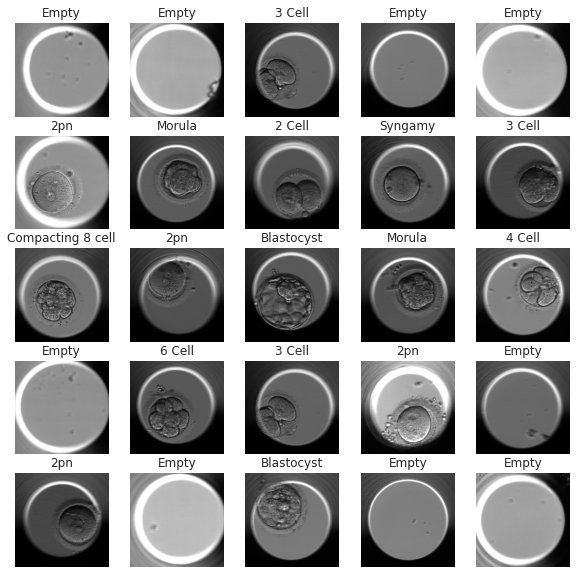

In [7]:
plt.figure(figsize=(10, 10))
sample = df.sample(25)
for i, (idx, row) in enumerate(sample.iterrows()):
    ax = plt.subplot(5, 5, i + 1)
    img = keras.utils.load_img(row.filename, target_size=(299,299))
    if EQUALIZE:
        img = tfa.image.equalize(img)
    plt.imshow(img)
    plt.title(row["class"])
    plt.axis("off")

In [8]:
train = tf.keras.utils.image_dataset_from_directory(
    BASE_DIR,
    image_size = (299,299),
    batch_size = BATCH_SIZE, #// 4, # / 4 here, because the augmentations will * 4
    label_mode = 'categorical',
    shuffle = False
)
if EQUALIZE:
    train_cache = train.map(lambda x, y: (tfa.image.equalize(x), y)).cache().prefetch(tf.data.AUTOTUNE)
else:
    train_cache = train.cache().prefetch(tf.data.AUTOTUNE)

Found 16414 files belonging to 12 classes.


2022-06-14 11:01:54.529175: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-14 11:01:54.530067: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-14 11:01:54.530289: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-14 11:01:54.530417: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [9]:
len(train_cache)

129

In [10]:
list(tqdm(train_cache)); # load it all into RAM

  0%|          | 0/129 [00:00<?, ?it/s]

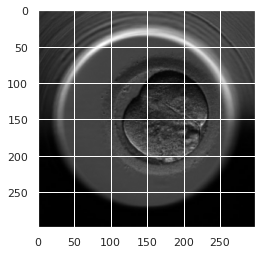

In [11]:
x, y = next(iter(train_cache))
plt.imshow(x.numpy()[0].astype("uint8"))

In [12]:
class AugmentationGenerator(tf.keras.utils.Sequence):
    def __getitem__(self, idx):
        x, y = next(iter(train_cache.skip(idx).take(1)))
        x = np.vstack([
            x,
            np.flip(x, axis=1),
            np.flip(x, axis=2),
            np.flip(np.flip(x, axis=1), axis=2),
        ])
        y = np.vstack([
            y, y, y, y
        ])
        return x, y
    def __len__(self):
        return len(train_cache)

x, y = AugmentationGenerator().__getitem__(0)
print(x.shape, y.shape)

(512, 299, 299, 3) (512, 12)


In [13]:
len(AugmentationGenerator())

129

In [14]:
classes = train.class_names
print(len(classes))
classes

12


['2 Cell',
 '2pn',
 '3 Cell',
 '4 Cell',
 '5 Cell',
 '6 Cell',
 '8 Cell',
 'Blastocyst',
 'Compacting 8 cell',
 'Empty',
 'Morula',
 'Syngamy']

In [15]:
base_model = keras.Sequential([
    # Pre-trained Xception weights requires that input be scaled
    # from (0, 255) to a range of (-1., +1.), the rescaling layer
    # outputs: `(inputs * scale) + offset`
    keras.layers.Rescaling(scale=1./127.5, offset=-1, input_shape=(299,299,3)),
    keras.applications.Xception(
        weights='imagenet',  # Load weights pre-trained on ImageNet.
        include_top=False,
        pooling="avg"
    )
])
base_model.save(f"models/xception.h5")
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 299, 299, 3)       0         
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                                 
Total params: 20,861,480
Trainable params: 20,806,952
Non-trainable params: 54,528
_________________________________________________________________


In [16]:
cachefile = f"extracted_features{'_eq' if EQUALIZE else ''}.npy"
print(cachefile)
try:
    extracted_features = np.load(cachefile)
    assert len(extracted_features) == len(train.file_paths)*4
except Exception as e:
    print(e)
    extracted_features = base_model.predict(AugmentationGenerator())
    np.save(cachefile, extracted_features)

extracted_features.npy


In [17]:
extracted_features.shape

(65656, 2048)

In [18]:
y = np.vstack([np.vstack([y,y,y,y]) for x,y in train])
y.shape

(65656, 12)

In [19]:
aug_paths = []
for i in range(len(train)):
    batch_paths = train.file_paths[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
    aug_paths.extend(batch_paths * 4)
aug_paths = pd.Series(aug_paths)
display(aug_paths)

0        EmbryoLabeling/Labelers/train/2 Cell/M0776_S00470_W2_F0_1894.jpg
1        EmbryoLabeling/Labelers/train/2 Cell/M0776_S00470_W2_F0_1914.jpg
2        EmbryoLabeling/Labelers/train/2 Cell/M0776_S00470_W2_F0_1934.jpg
3        EmbryoLabeling/Labelers/train/2 Cell/M0776_S00470_W2_F0_1954.jpg
4        EmbryoLabeling/Labelers/train/2 Cell/M0776_S00470_W2_F0_1974.jpg
                                       ...                               
65651     EmbryoLabeling/Labelers/train/Syngamy/M776_S0087_W5_F0_1555.jpg
65652     EmbryoLabeling/Labelers/train/Syngamy/M776_S0087_W5_F0_1585.jpg
65653     EmbryoLabeling/Labelers/train/Syngamy/M776_S0087_W5_F0_1605.jpg
65654     EmbryoLabeling/Labelers/train/Syngamy/M776_S0087_W5_F0_1625.jpg
65655     EmbryoLabeling/Labelers/train/Syngamy/M776_S0087_W5_F0_1645.jpg
Length: 65656, dtype: object

In [20]:
fert_minutes = aug_paths.apply(lambda s: s.replace(".jpg", "").split("_")[-1]).astype(int)
fert_minutes

0        1894
1        1914
2        1934
3        1954
4        1974
         ... 
65651    1555
65652    1585
65653    1605
65654    1625
65655    1645
Length: 65656, dtype: int64

In [21]:
extracted_features_with_fert = np.hstack([extracted_features, fert_minutes.to_numpy()[:, None]])
extracted_features_with_fert.shape

(65656, 2049)

In [22]:
#x_train, x_test, y_train, y_test = train_test_split(extracted_features, y, test_size=.2)

# Use one slide for test, everything else for train
test_slide = "M0776_S00512"
test_idx = aug_paths.str.contains(test_slide)
x_train = extracted_features_with_fert[~test_idx]
y_train = y[~test_idx]
x_test = extracted_features_with_fert[test_idx]
y_test = y[test_idx]
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((56508, 2049), (56508, 12), (9148, 2049), (9148, 12))

In [23]:
class_weights = class_weight.compute_class_weight('balanced', classes = np.unique(y.argmax(axis=1)), y=y.argmax(axis=1))
class_weights = class_weights.round(6) # This is necessary if using mlflow, as it can go beyond the 250 character limit otherwise
class_weights = dict(enumerate(class_weights))
{k:v for k,v in zip(classes, class_weights.values())}

{'2 Cell': 1.356978,
 '2pn': 0.716143,
 '3 Cell': 3.667113,
 '4 Cell': 1.626437,
 '5 Cell': 6.873534,
 '6 Cell': 3.166281,
 '8 Cell': 3.173627,
 'Blastocyst': 0.638876,
 'Compacting 8 cell': 2.4915,
 'Empty': 0.231326,
 'Morula': 0.832522,
 'Syngamy': 1.404346}

In [24]:
# Hyperparameter search
search = False
if search:
    def build_model(hp):
        model = keras.Sequential()
        model.add(keras.layers.Input(shape=(2048)))

        for i in range(hp.Int("n_layers", 1, 4)):
            model.add(keras.layers.Dense(
                hp.Int(f"dense_units_{i}", min_value=32, max_value=128, step=32),
                activation=hp.Choice(f"dense_activation_{i}", values=["relu", "sigmoid"], default="relu")
            ))
            model.add(keras.layers.Dropout(hp.Float(f"dropout_{i}", min_value=.1, max_value=.5, step=.1)))

        model.add(keras.layers.Dense(len(classes), activation="softmax"))
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=hp.Float(
                "learning_rate", min_value=1e-4, max_value=1e-2, sampling="LOG", default=1e-3
            )),
            loss=keras.losses.CategoricalCrossentropy(),
            metrics=[keras.metrics.CategoricalAccuracy()],
        )
        return model

    tuner = RandomSearch(
        build_model,
        objective="val_categorical_accuracy",
        max_trials=80,
    )
    tuner.search_space_summary()
    tuner.search(
        x_train,
        y_train,
        batch_size=BATCH_SIZE,
        validation_data=(x_test, y_test),
        epochs=500,
        verbose=0,
        class_weight=class_weights,
        callbacks=[
            keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy',patience=50, verbose=1),
            tfa.callbacks.TQDMProgressBar()
        ]
    )
    print(tuner.get_best_hyperparameters()[0].values)
    print(tuner.get_best_models()[0].summary())

In [25]:
%%time
with mlflow.start_run():
    mlflow.log_params({
        "classes": classes,
        "equalized": EQUALIZE,
        "test slide": test_slide,
        "x_train_shape": x_train.shape,
        "y_train_shape": y_train.shape,
        "x_test_shape": x_test.shape,
        "y_test_shape": y_test.shape
    })

    model = keras.Sequential([
        keras.layers.Input(shape=(x_train.shape[1])),
        keras.layers.Dense(512, activation="relu"),
        keras.layers.Dense(512, activation="relu"),
        keras.layers.Dense(len(classes), activation="softmax")
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=keras.optimizers.schedules.ExponentialDecay(
            .001,
            decay_steps=1e4,
            decay_rate=0.96,
            staircase=True
        )),
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=[keras.metrics.CategoricalAccuracy()],
    )
    print(model.summary())
    history = model.fit(x_train,
                        y_train,
                        batch_size=BATCH_SIZE,
                        validation_data=(x_test, y_test),
                        epochs=500,
                        verbose=0,
                        class_weight=class_weights,
                        callbacks=[
                            keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy',patience=50, verbose=1),
                            tfa.callbacks.TQDMProgressBar()
                        ])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               1049600   
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 12)                6156      
                                                                 
Total params: 1,318,412
Trainable params: 1,318,412
Non-trainable params: 0
_________________________________________________________________
None


Training:   0%|           0/500 ETA: ?s,  ?epochs/s

Epoch 1/500


0/442           ETA: ?s - 

Epoch 2/500


0/442           ETA: ?s - 

Epoch 3/500


0/442           ETA: ?s - 

Epoch 4/500


0/442           ETA: ?s - 

Epoch 5/500


0/442           ETA: ?s - 

Epoch 6/500


0/442           ETA: ?s - 

Epoch 7/500


0/442           ETA: ?s - 

Epoch 8/500


0/442           ETA: ?s - 

Epoch 9/500


0/442           ETA: ?s - 

Epoch 10/500


0/442           ETA: ?s - 

Epoch 11/500


0/442           ETA: ?s - 

Epoch 12/500


0/442           ETA: ?s - 

Epoch 13/500


0/442           ETA: ?s - 

Epoch 14/500


0/442           ETA: ?s - 

Epoch 15/500


0/442           ETA: ?s - 

Epoch 16/500


0/442           ETA: ?s - 

Epoch 17/500


0/442           ETA: ?s - 

Epoch 18/500


0/442           ETA: ?s - 

Epoch 19/500


0/442           ETA: ?s - 

Epoch 20/500


0/442           ETA: ?s - 

Epoch 21/500


0/442           ETA: ?s - 

Epoch 22/500


0/442           ETA: ?s - 

Epoch 23/500


0/442           ETA: ?s - 

Epoch 24/500


0/442           ETA: ?s - 

Epoch 25/500


0/442           ETA: ?s - 

Epoch 26/500


0/442           ETA: ?s - 

Epoch 27/500


0/442           ETA: ?s - 

Epoch 28/500


0/442           ETA: ?s - 

Epoch 29/500


0/442           ETA: ?s - 

Epoch 30/500


0/442           ETA: ?s - 

Epoch 31/500


0/442           ETA: ?s - 

Epoch 32/500


0/442           ETA: ?s - 

Epoch 33/500


0/442           ETA: ?s - 

Epoch 34/500


0/442           ETA: ?s - 

Epoch 35/500


0/442           ETA: ?s - 

Epoch 36/500


0/442           ETA: ?s - 

Epoch 37/500


0/442           ETA: ?s - 

Epoch 38/500


0/442           ETA: ?s - 

Epoch 39/500


0/442           ETA: ?s - 

Epoch 40/500


0/442           ETA: ?s - 

Epoch 41/500


0/442           ETA: ?s - 

Epoch 42/500


0/442           ETA: ?s - 

Epoch 43/500


0/442           ETA: ?s - 

Epoch 44/500


0/442           ETA: ?s - 

Epoch 45/500


0/442           ETA: ?s - 

Epoch 46/500


0/442           ETA: ?s - 

Epoch 47/500


0/442           ETA: ?s - 

Epoch 48/500


0/442           ETA: ?s - 

Epoch 49/500


0/442           ETA: ?s - 

Epoch 50/500


0/442           ETA: ?s - 

Epoch 51/500


0/442           ETA: ?s - 

Epoch 52/500


0/442           ETA: ?s - 

Epoch 53/500


0/442           ETA: ?s - 

Epoch 54/500


0/442           ETA: ?s - 

Epoch 55/500


0/442           ETA: ?s - 

Epoch 56/500


0/442           ETA: ?s - 

Epoch 57/500


0/442           ETA: ?s - 

Epoch 58/500


0/442           ETA: ?s - 

Epoch 59/500


0/442           ETA: ?s - 

Epoch 60/500


0/442           ETA: ?s - 

Epoch 60: early stopping
INFO:tensorflow:Assets written to: /tmp/tmp4w26fgpm/model/data/model/assets
CPU times: user 4min 4s, sys: 44.4 s, total: 4min 48s
Wall time: 2min 56s


In [26]:
model.save(f"models/{len(classes)}_class.h5")

<AxesSubplot:>

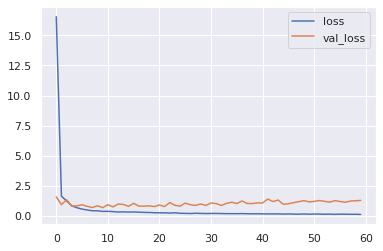

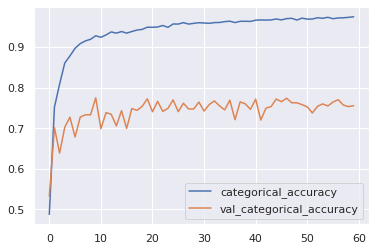

In [27]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['categorical_accuracy', 'val_categorical_accuracy']].plot()

In [28]:
y_pred = model.predict(x_test)

286/286 [==============================] - 1s 2ms/step


In [29]:
predicted_codes = y_pred.argmax(axis=1)
confidence = y_pred.max(axis=1)
pd.Series(confidence).describe()

count    9148.000000
mean        0.935547
std         0.123901
min         0.322754
25%         0.944824
50%         0.997559
75%         1.000000
max         1.000000
dtype: float64

In [30]:
true_classes = [classes[c] for c in y_test.argmax(axis=1)]
pd.Series(true_classes).value_counts()

Morula               1520
Empty                1340
2pn                  1188
Blastocyst           1068
Syngamy               976
4 Cell                652
2 Cell                608
8 Cell                524
Compacting 8 cell     476
6 Cell                312
3 Cell                260
5 Cell                224
dtype: int64

In [31]:
validation_df = pd.DataFrame()
validation_df["true_class"] = true_classes
validation_df["predicted_class"] = [classes[c] for c in predicted_codes]
validation_df["confidence"] = confidence
validation_df

,true_class,predicted_class,confidence
0,2 Cell,2 Cell,1.000000
1,2 Cell,2 Cell,1.000000
2,2 Cell,2 Cell,1.000000
3,2 Cell,2 Cell,0.974609
4,2 Cell,2 Cell,0.981934
...,...,...,...
9143,Syngamy,Syngamy,0.927246
9144,Syngamy,2pn,0.998535
9145,Syngamy,2pn,0.998047
9146,Syngamy,Syngamy,1.000000


In [32]:
validation_df.groupby("predicted_class").confidence.median()

predicted_class
2 Cell               0.995117
2pn                  1.000000
3 Cell               0.864258
4 Cell               0.962402
5 Cell               0.752930
6 Cell               0.917969
8 Cell               0.758301
Blastocyst           0.999512
Compacting 8 cell    0.904297
Empty                1.000000
Morula               0.993652
Syngamy              1.000000
Name: confidence, dtype: float16

In [33]:
validation_df.to_csv("validation_predictions.csv", index=False)

                   precision    recall  f1-score   support

           2 Cell       0.72      0.87      0.79       608
              2pn       0.87      0.96      0.91      1188
           3 Cell       0.14      0.25      0.18       260
           4 Cell       0.49      0.37      0.42       652
           5 Cell       0.12      0.08      0.10       224
           6 Cell       0.25      0.41      0.31       312
           8 Cell       0.57      0.21      0.30       524
       Blastocyst       0.97      0.87      0.92      1068
Compacting 8 cell       0.51      0.46      0.49       476
            Empty       1.00      1.00      1.00      1340
           Morula       0.83      0.94      0.88      1520
          Syngamy       0.93      0.79      0.86       976

         accuracy                           0.76      9148
        macro avg       0.62      0.60      0.60      9148
     weighted avg       0.77      0.76      0.75      9148

[  0.    0.    0.    0.    0.    0.    0.    4.1  40.

Text(66.5, 0.5, 'True')

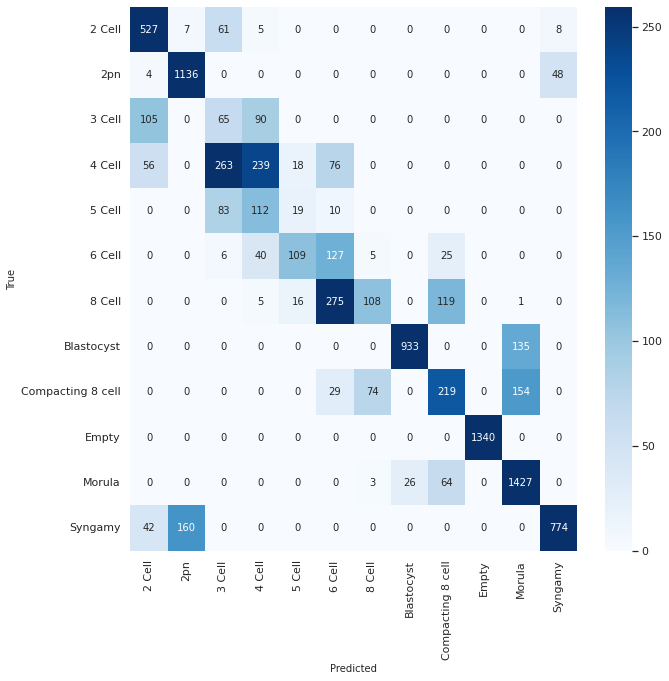

In [34]:
print(classification_report(validation_df["true_class"], validation_df["predicted_class"]))
confusion = confusion_matrix(validation_df["true_class"], validation_df["predicted_class"])
print(np.quantile(confusion, np.arange(0, 1, .1)))
plt.figure(figsize=(10,10))
s = sns.heatmap(
    confusion,
    annot=True,
    cmap='Blues',
    fmt="g",
    xticklabels=classes,
    yticklabels=classes,
    vmax=np.quantile(confusion, .95)
)
s.set_xlabel('Predicted', fontsize=10)
s.set_ylabel('True', fontsize=10)